## Yolo11 tests

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os , sys
import shutil
from tqdm.auto import tqdm  
sys.path.append('..')
from pathlib import Path
cur_path = Path(os.getcwd()).parent
sam2_path = cur_path / 'sam2_octron'
sys.path.append(cur_path.as_posix())
from matplotlib import pyplot as plt
import cmasher as cmr
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [ ]:
from napari_pyav._reader import FastVideoReader
from octron.sam2_octron.helpers.video_loader import get_vfile_hash
from octron.yolo_octron.helpers.training import (collect_labels, 
                                                 pick_random_frames,
                                                 find_common_frames,
                                                 draw_polygons,
                                                 train_test_val,
                                                 write_training_data,
                                                 write_yolo_config_yaml,
                                                 
)
from octron.yolo_octron.helpers.polygons import (find_objects_in_mask, 
                                                 watershed_mask,
                                                 get_polygons,
)
from octron.sam2_octron.helpers.sam2_zarr import load_image_zarr

In [ ]:
# Presaved model (YOLOv11)
path_to_model = Path('/Users/horst/Documents/python/OCTRON/octron/yolo_octron/yolo11l-seg.pt')
project_path = Path('/Users/horst/Downloads/octron_project_2')
assert project_path.exists()
assert path_to_model.exists()

In [ ]:
from zarr.core import array # For type checking 

### Find out what info is present across object organizers / ...

- Construct a nice loop that finds the zarr, video files, and compares video file hashes 


In [ ]:
project_path

In [ ]:
label_dict = collect_labels(project_path, prune_empty_labels=True, verbose=False)

In [ ]:
labels = label_dict['/Users/horst/Downloads/octron_project_2/7c724296']

In [31]:
min_area = None

for entry in labels:
    if entry == 'video':
        continue
    label = labels[entry]['label']
    frames = labels[entry]['frames']
    mask_arrays = labels[entry]['masks'] # zarr array
    
    # On a subset of masks, determine object properties
    random_frames = pick_random_frames(frames, n=10)
    obj_diameters = []
    for f in random_frames:
        for mask_array in mask_arrays:
            sample_mask = mask_array[f]
            if sample_mask.sum() == 0:
                continue
            else:
                if min_area is None:
                    # Determine area threshold once
                    # threshold at 0.1 percent of the image area
                    min_area = 0.001*sample_mask.shape[0]*sample_mask.shape[1]
                l, r = find_objects_in_mask(sample_mask, 
                                           min_area=min_area
                                           ) 
                for r_ in r:
                    obj_diameters.append(r_.feret_diameter_max)
                    
    # Now you can make assumptions about the median diameter of the objects
    # I use this for "optimal" watershed parameters 
    median_obj_diameter = np.nanmedian(obj_diameters)

    ##################################################################################
    
    polys = {} # Collected polygons over frames
    for frame in tqdm(frames, desc=f'Polygons for label {label}'):    
        mask_polys = [] # List of polygons for the current frame
        for mask_array in mask_arrays:
            mask_current_array = mask_array[frame]
            # Watershed
            _, water_masks = watershed_mask(mask_current_array,
                                            footprint_diameter=median_obj_diameter,
                                            min_size_ratio=0.1,    
                                            plot=False
                                           )
            # Loop over watershedded masks
            for mask in water_masks:
                try:
                    mask_polys.append(get_polygons(mask)) 
                except AssertionError:
                    # The mask is empty at this frame.
                    # This happens if there is more than one mask 
                    # zarr array (because there are multiple instances of a label), 
                    # and the current label is not present in the current mask array.
                    pass    
        polys[frame] = mask_polys
    labels[entry]['polygons'] = polys  

Polygons for label worm:   0%|          | 0/57 [00:00<?, ?it/s]

Polygons for label led:   0%|          | 0/57 [00:00<?, ?it/s]

Drawing polygons for 3 labels.
1 frame(s) per label max. will be plotted.


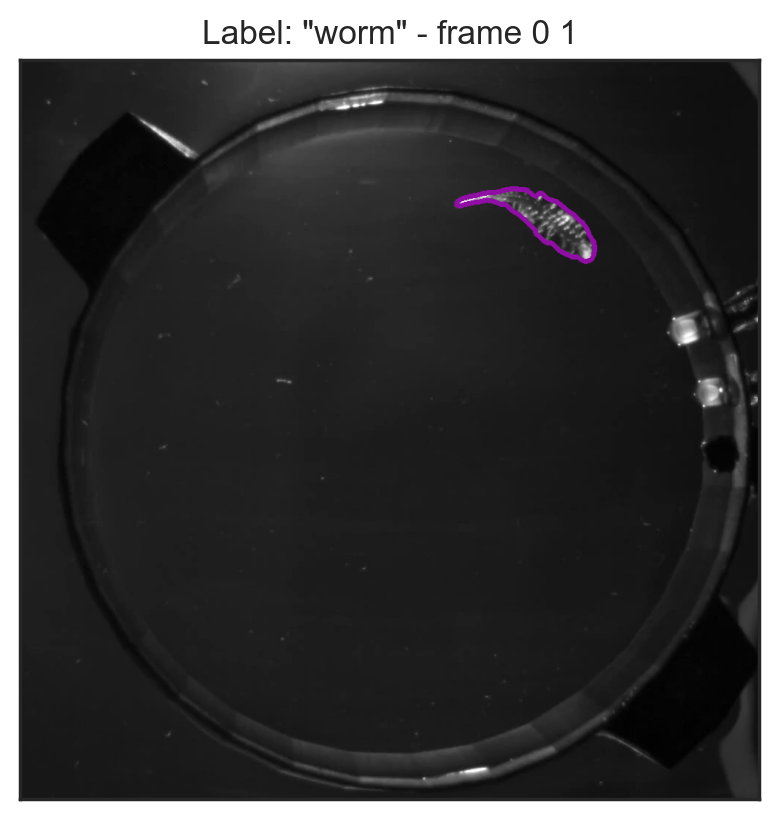

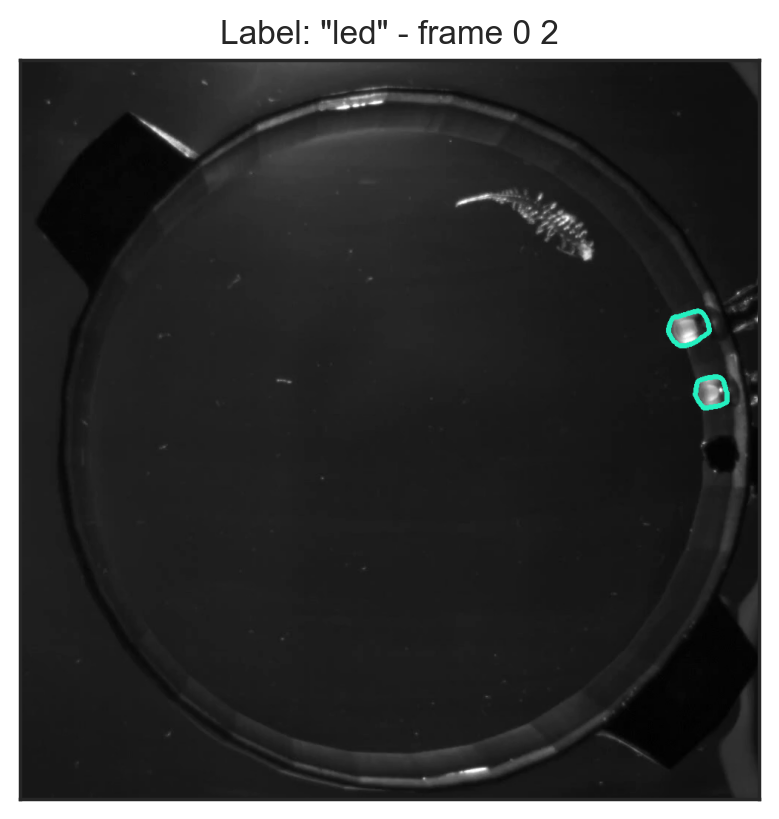

In [32]:
draw_polygons(labels, labels['video'], 
              max_to_plot=1,
              )   

In [ ]:
# # Video reader 
# video_dict = probe_video(path_to_video)
# video_data = FastVideoReader(path_to_video)  

### Process training data

In [ ]:
# organizer_dict = load_object_organizer(path_to_json_organizer)  
# assert organizer_dict is not None
# labels = collect_labels(organizer_dict,
#                         )

In [ ]:
#draw_polygons(labels, video_data, 2)

In [ ]:
# # Perform the split of the data
# # .. 80% training, 10% validation and 10% testing
# print('Splitting the data for training into training, validation and testing fractions')  
# for label_id, label_dict in labels.items():
#     print(label_dict['label'])
#     label_split = train_test_val(label_dict['frames'], 
#                                  training_fraction=0.8,
#                                  validation_fraction=0.1,
#                                  verbose=True)
#     labels[label_id]['frames_split'] = label_split

In [ ]:
# # Now export the data to the respective directories
# # We need to export the images and the labels
# for split in ['train', 'val', 'test']:
#     path_to_split = path_to_training_root / split
#     try:
#         path_to_split.mkdir(exist_ok=False)
#     except FileExistsError:
#         shutil.rmtree(path_to_split)    
#         path_to_split.mkdir()

# write_training_data(labels,
#                     path_to_training_root,
#                     video_data,
# )

In [ ]:
# # Example usage
# dataset_path = path_to_training_root
# train_path = "train"  
# val_path = "val"
# test_path = "test"

# # Get label names from your object organizer
# label_id_label_dict = {}
# for label_id, label_dict in labels.items():
#     label_id_label_dict[label_id] = label_dict['label']

# # Write the YAML config
# config_path = path_to_training_root / "yolo_config.yaml"
# write_yolo_config_yaml(
#     output_path=config_path,
#     dataset_path=dataset_path,
#     train_path=train_path,
#     val_path=val_path,
#     test_path=test_path,
#     label_dict=label_id_label_dict
# )

## YOLO setup

In [ ]:
# from ultralytics import YOLO
# from ultralytics import settings
# settings.update({'sync': False,'hub':False, })
# runs_output_dir = config_path.parent / 'yolo runs'   
# settings.update({'datasets_dir': '','weights_dir':'', 'runs_dir': runs_output_dir.as_posix()})
# settings.update()

In [ ]:
# # Load a model
# model = YOLO(path_to_model)  # load a pretrained model (recommended for training)
# # Train the model
# # https://docs.ultralytics.com/usage/cfg/#solutions-settings
# results = model.train(data=config_path, 
#                       save_dir=runs_output_dir.as_posix(),
#                       device='cpu',
#                       mask_ratio=4,
#                       epochs=60,
#                       imgsz=640,
#                       resume=False,
#                       plots=True,
#                       batch=.85,
#                       cache=False,
#                       save=True,
#                       save_period=15,
#                       project=None,
#                       name=None,
#                       exist_ok=True,
#                       # augmentation
#                       hsv_v=.25,
#                       degrees=180,
#                       scale=.5,
#                       shear=2,
#                       flipud=.1,
#                       fliplr=.1,
#                       mosaic=1.0,
#                       copy_paste=.5,
#                       copy_paste_mode='mixup', 
#                       erasing=.25,
#                       crop_fraction=1.0,
#                       )

In [ ]:
# model = YOLO('/Users/horst/Downloads/octron_project/octron_training/yolo runs/segment/train/weights/last.pt')  #

In [ ]:
# metrics = model.val(device='cpu', plots=True)

In [ ]:
# print("Mean Average Precision for boxes:", metrics.box.map)
# print("Mean Average Precision for masks:", metrics.seg.map)

In [ ]:
# # Run inference on 'bus.jpg' with arguments
# model.predict('/Users/horst/Downloads/octron_project/test data/8_behaviour_filtered2024-11-04T14_20_34_20240930_Th19.mp4', 
#               save=True, 
#               classes=[0],
#               imgsz=1000, 
#               device='cpu',
#               visualize=False,
#               conf=0.9
#               )

In [ ]:
# # Train/val/test sets as 
# 1) dir: path/to/imgs, 
# 2) file: path/to/imgs.txt, or list: [path/to/imgs1, path/to/imgs2, ..]
# path: ../datasets/coco8-seg # dataset root dir (absolute or relative; if relative, it's relative to default datasets_dir)
# train: images/train # train images (relative to 'path') 4 images
# val: images/val # val images (relative to 'path') 4 images
# test: # test images (optional)
